# Met Office UKV high-resolution atmosphere model data

{opticon}`tag`
{bdg-primary}`Urban`
{bdg-secondary}`Exploration`
{bdg-warning}`Regular`
{bdg-info}`Python`

[![RoHub - FAIR Executable Research Object](https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue)](https://w3id.org/ro-id/1b8921af-e77f-4ccf-ae38-4813cdceba0f)

[![Binder](https://mybinder.org/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/eds-book-gallery/1b8921af-e77f-4ccf-ae38-4813cdceba0f/main?labpath=notebook.ipynb)

[![DOI](https://zenodo.org/badge/DOI/10.24424/pbvr-gd04.svg)](https://doi.org/10.24424/pbvr-gd04)

## Context
### Purpose
To load, plot, regrid and extract an urban region from the UKV gridded model data using the [Iris package](https://scitools-iris.readthedocs.io/en/stable/).

### Sensor description
Met Office UKV model data is fairly high resolution (approximately 1 km horizontal) and available over the whole of the UK for a variety of atmospheric variables at surface and pressure levels. A selection of variables has been
made openly available as part of the Met Office contribution to the COVID 19 modelling effort. A selection of variables at hourly and daily frequency in NetCDF format can be obtained from [this landing page](https://metdatasa.blob.core.windows.net/covid19-response-non-commercial/README.html). 

This notebook uses a single sample data file for 1.5 m temperature included with the notebook.

### Highlights
* Data for the whole UK is loaded and plotted using Iris
* Data is regridded to a geographic projection 
* A region over London is extracted

### Contributions

#### Notebook
* Samantha V. Adams (author), Met Office Informatics Lab, [@svadams](https://github.com/svadams)
* Alejandro Coca-Castro (reviewer), The Alan Turing Institute, [@acocac](https://github.com/acocac)

#### Dataset originator/creator
* Met Office Informatics Lab (creator)
* Microsoft (support)
* European Regional Development Fund (support)

#### Dataset authors
* Met Office

#### Dataset documentation
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "1b8921af-e77f-4ccf-ae38-4813cdceba0f"
```

:::{note}
Note this data should be used only for non-commercial purposes.
:::

## Install and load libraries

In [1]:
import os
import iris
import iris.analysis
import iris.plot as iplt
from iris.coords import DimCoord
from iris.coord_systems import GeogCS
from iris.cube import Cube

from iris.fileformats.pp import EARTH_RADIUS

import requests
import urllib.request
import pooch

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

## Set project structure

In [2]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Retrieve and load a sample data file

In [3]:
filepath = 'https://metdatasa.blob.core.windows.net/covid19-response-non-commercial/metoffice_ukv_daily/t1o5m_mean/'
filename = 'ukv_daily_t1o5m_mean_20150801.nc'

response = requests.get(filepath+filename)
if response.status_code == 200:
    urllib.request.urlretrieve(filepath+filename, os.path.join(notebook_folder, filename))
else:
    pooch.retrieve(
        url="doi:10.5281/zenodo.7087009/ukv_daily_t1o5m_mean_20150801.nc",
        known_hash="md5:b71e092ead092f419f12073ddf2d3256",
        path=notebook_folder,
        fname="ukv_daily_t1o5m_mean_20150801.nc"
    )

In [4]:
air_temp = iris.load_cube(os.path.join(notebook_folder, filename))
air_temp.coord('grid_latitude').guess_bounds()
air_temp.coord('grid_longitude').guess_bounds()

## Visualisation

Here we use the Iris wrapper to matplotlib pyplot to plot the gridded data with added gridlines and coastline.

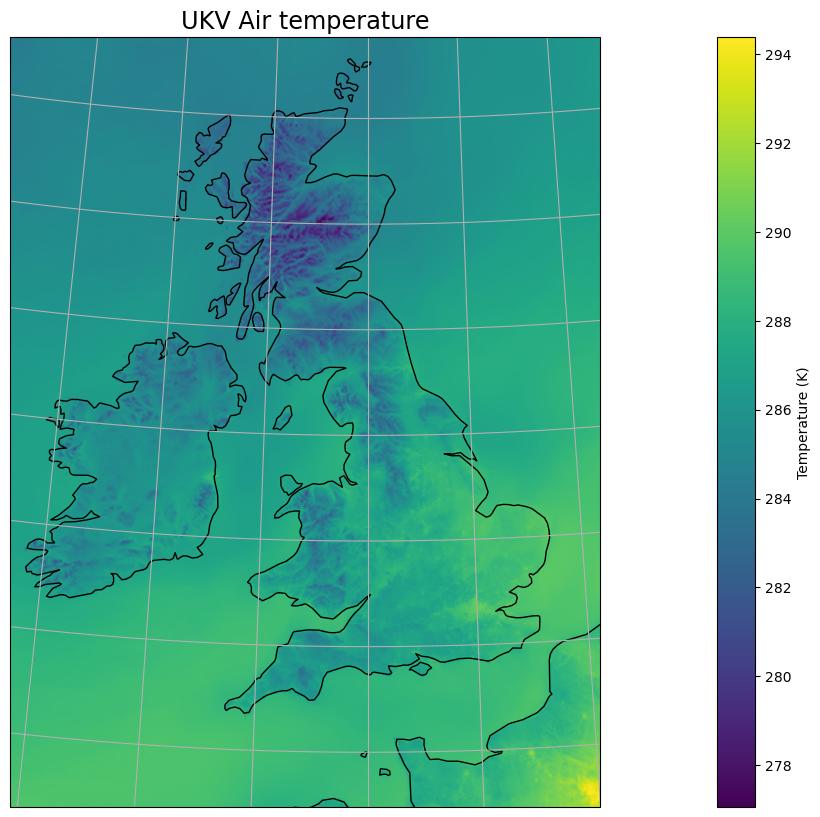

In [5]:
plt.figure(figsize=(30, 10))
iplt.pcolormesh(air_temp)
plt.title("UKV Air temperature", fontsize="xx-large")
cbar = plt.colorbar()
cbar.set_label('Temperature (' + str(air_temp.units) + ')')
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

## Regridding from Azimuthal equal-area projection to geographic

### Create a target cube with a lat-lon coord system for regrid

It is filled with random data so we can plot it to check it looks correct.

In [6]:
latitude = DimCoord(np.linspace(48.5, 59.5, 1222),
                    standard_name='latitude',
                    coord_system = GeogCS(EARTH_RADIUS),
                    units='degrees')
longitude = DimCoord(np.linspace(-10.5, 2.0, 1389),
                     standard_name='longitude',
                    coord_system = GeogCS(EARTH_RADIUS),                     
                     units='degrees')
global_cube = Cube(np.random.uniform(low=0.0, high=1.0, size=(1222, 1389)),
                   dim_coords_and_dims=[(latitude, 0),
                                        (longitude, 1)])

global_cube.coord('latitude').guess_bounds()
global_cube.coord('longitude').guess_bounds()

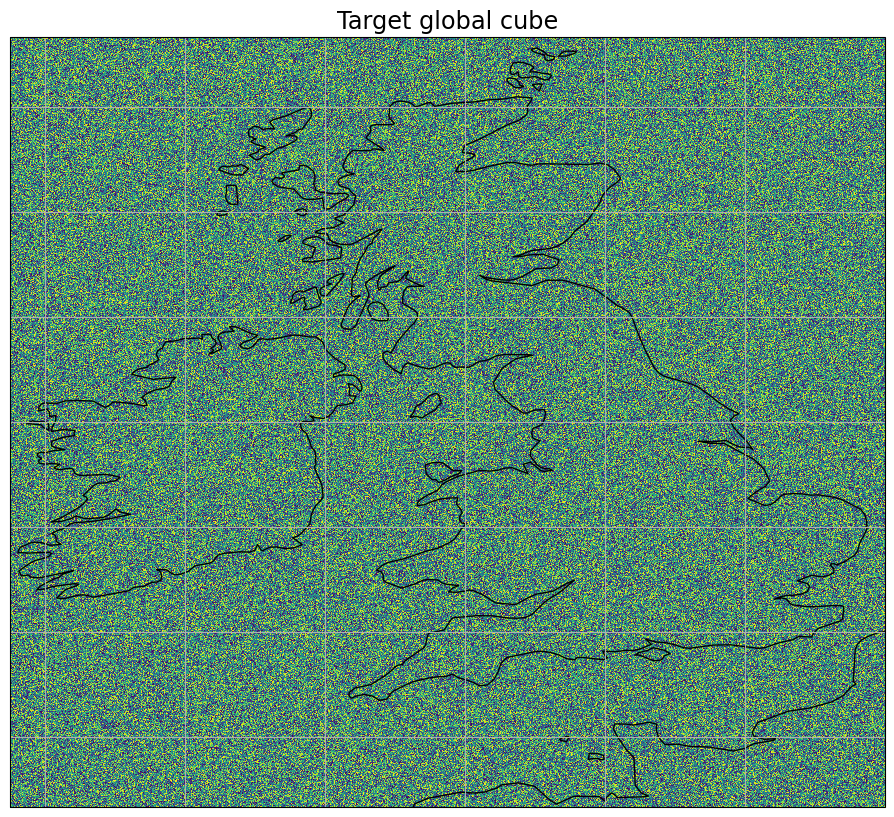

In [7]:
plt.figure(figsize=(30, 10))
iplt.pcolormesh(global_cube)
plt.title("Target global cube", fontsize="xx-large")
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

### Perform the regridding from source data cube to target cube

In [8]:
# Note we need to use extrapolation masking in case regridded source data is actually smaller
# than the target cube extents
global_air_temp = air_temp.regrid(global_cube, iris.analysis.Linear(extrapolation_mode="mask"))

### Plot the regridded data to check it is correct

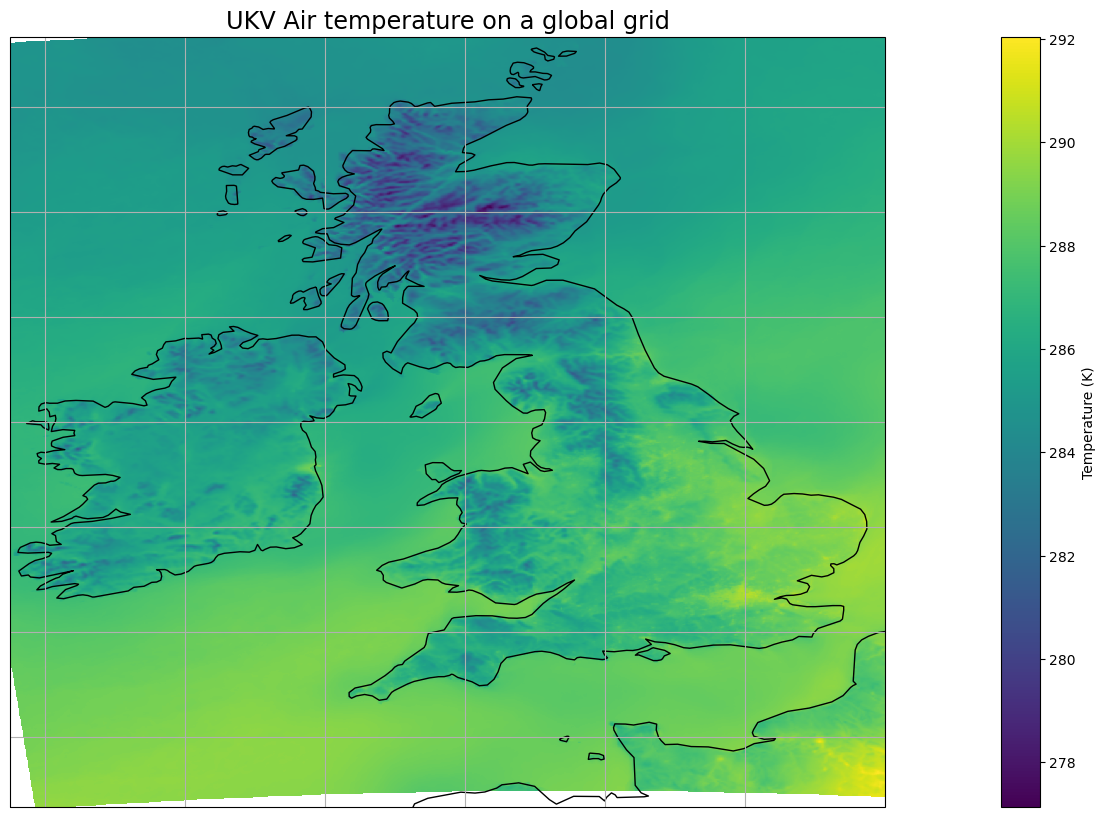

In [9]:
plt.figure(figsize=(30, 10))

iplt.pcolormesh(global_air_temp)
plt.title("UKV Air temperature on a global grid", fontsize="xx-large")
cbar = plt.colorbar()
cbar.set_label('Temperature (' + str(global_air_temp.units) + ')')
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

## Extract the London Region

### Use the Iris Intersection method and supply the region lat-lon bounds

In [10]:
min_lon = -0.52
min_lat = 51.3
max_lon = 0.3
max_lat = 51.7

air_temp_london = global_air_temp.intersection(longitude=(min_lon, max_lon), latitude=(min_lat, max_lat))

### Plot the results

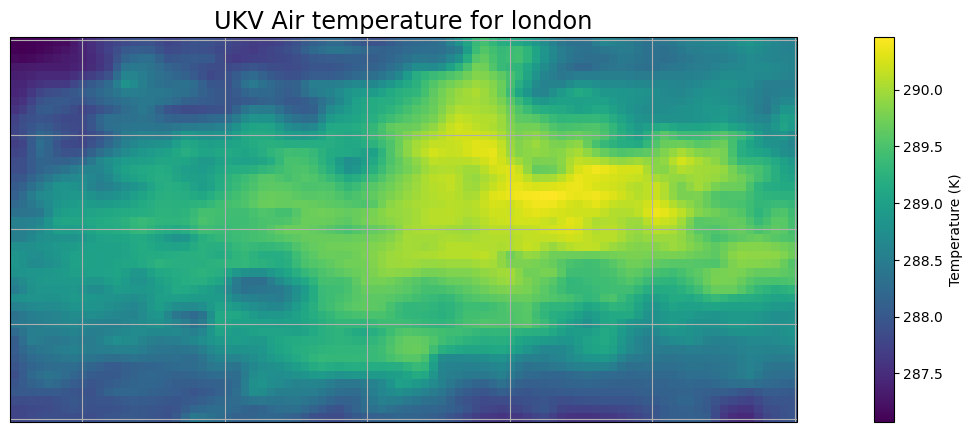

In [11]:
plt.figure(figsize=(20, 5))

iplt.pcolormesh(air_temp_london)
plt.title("UKV Air temperature for london", fontsize="xx-large")
cbar = plt.colorbar()
cbar.set_label('Temperature (' + str(air_temp_london.units) + ')')
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

plt.show()

### Save as a new NetCDF file

In [12]:
iris.save(air_temp_london, os.path.join(notebook_folder,'ukv_london_sample.nc'))

## Summary

This notebook has demonstrated the use of the `Iris` package to easily load, plot and manipulate gridded environmental NetCDF data.

## Citing this Notebook

Samantha Adams, and Alejandro Coca-Castro. "Met Office UKV high-resolution atmosphere model data (Jupyter Notebook) published in the Environmental Data Science book." ROHub. Feb 06 ,2022. https://doi.org/10.24424/pbvr-gd04.

## Additional information

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [13]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-03-20
